In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from numpy.typing import NDArray
from scipy.optimize import minimize
from typing import List, Tuple
import time as time
import pandas as pd
import japanize_matplotlib

In [2]:
# 価格を生成する関数
def create_price(r_mean: float, r_std: float, M: int) -> NDArray[np.float_]:
    # r_mean = (r_min + r_max) / 2
    # r_std = (r_max - r_mean) / 2
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.normal(r_mean, r_std, size=M)
    # price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-3 * M, -2 * M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 3)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


def create_date(M, N, r_mean, r_std, delta=0.1):
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    price_list = []
    quantity_list = []

    for _ in range(N):
        price = create_price(r_mean, r_std, M)
        quantity = quantity_function(price, alpha, beta, delta)
        price_list.append(price)
        quantity_list.append(quantity)

    X = np.array(price_list)
    Y = np.array(quantity_list)

    return alpha, beta, X, Y


def create_bounds(M, r_min, r_max):
    lb = np.full(M, r_min)
    ub = np.full(M, r_max)

    range_bounds = []
    for i in range(M):
        range_bounds.append(lb[i])

    for i in range(M):
        range_bounds.append(ub[i])

    bounds = [(r_min, r_max) for _ in range(M)]

    return lb, ub, bounds, range_bounds


In [3]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    bounds: list[tuple[float, float]],
) -> Tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)

    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [4]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], bounds: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [5]:
# CVを行う関数
def cross_validation(
    tilda_coefs_list: list[NDArray[np.float_]],
    tilda_intercepts_list: list[float],
    hat_coefs_list: list[NDArray[np.float_]],
    hat_intercepts_list: list[float],
    M: int,
    K: int,
    bounds: list[float],
) -> float:
    optimal_sales_list = []

    for i in range(K):
        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(tilda_intercepts_list[i], tilda_coefs_list[i], M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        sales_hat = np.sum(
            sales_function(optimal_prices, hat_intercepts_list[i], hat_coefs_list[i])
        )

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


In [6]:
### 変更後の cross_validation_bounds_zero_2
def cross_validation_bounds_zero(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
) -> float:
    # bounds から (low, high) の形式に変換
    bounds_list = []
    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return 0.0
        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    optimal_sales_list = []

    for i in range(K):
        # tildaパラメータで最適化（学習済み）
        intercepts = tilda_intercepts_list[i]
        coefs = tilda_coefs_list[i]

        initial_prices = np.full(M, 0.6)
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        optimal_prices = result.x

        # 得られた最適価格でhatパラメータに基づく売上計算
        alpha = hat_intercepts_list[i]
        beta = hat_coefs_list[i]

        sales_hat = np.sum(sales_function(optimal_prices, alpha, beta))
        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


def estimate_bounds_zero_nelder(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
    r_min: float,
    r_max: float,
    adaptive: bool = True,
) -> Tuple[float, List[Tuple[float, float]]]:
    # Nelder-Meadでの最適化
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds


In [22]:
def cross_validation_bounds_penalty_all_2(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
    bounds_range: float,
) -> float:
    # bounds の整合性チェック
    for i in range(M):
        if bounds[i] > bounds[i + M]:
            # ペナルティ計算
            return 0.0
    bounds_list = [(bounds[i], bounds[i + M]) for i in range(M)]
    optimal_sales_list = []

    # すでに外部でKFold分割や学習が終わっているものとして
    # tilda_coefs_list[i], tilda_intercepts_list[i], hat_coefs_list[i], hat_intercepts_list[i]
    # を使用して最適化と売上計算
    for i in range(K):
        intercepts = tilda_intercepts_list[i]
        coefs = tilda_coefs_list[i]

        # 最適化
        initial_prices = np.full(M, 0.6)
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        optimal_prices = result.x

        # hatモデルパラメータで売上計算
        alpha = hat_intercepts_list[i]
        beta = hat_coefs_list[i]

        sales_hat = np.sum(sales_function(optimal_prices, alpha, beta))
        optimal_sales_list.append(sales_hat)

    mean_sales = np.mean(optimal_sales_list)
    # ペナルティ計算
    penalty = 0.0
    for i in range(M):
        penalty += bounds[i + M] - bounds[i]
    print(penalty)

    if penalty > M * bounds_range:
        return 0
    else:
        return -mean_sales


def estimate_bounds_penalty_nelder_all_2(
    bounds: List[float],
    tilda_coefs_list: List[NDArray[np.float_]],
    tilda_intercepts_list: List[NDArray[np.float_]],
    hat_coefs_list: List[NDArray[np.float_]],
    hat_intercepts_list: List[NDArray[np.float_]],
    M: int,
    K: int,
    r_min: float,
    r_max: float,
    bounds_range: float,
    adaptive: bool = True,
) -> Tuple[float, List[Tuple[float, float]]]:
    # Nelder-Meadでの最適化
    bounds_nelder = minimize(
        cross_validation_bounds_penalty_all_2,
        bounds,
        args=(
            tilda_coefs_list,
            tilda_intercepts_list,
            hat_coefs_list,
            hat_intercepts_list,
            M,
            K,
            bounds_range,
        ),
        method="Nelder-Mead",
        bounds=[(r_min, r_max) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds


In [20]:
# 実験設定

M = 5
K = 5
N = 500
r_mean = 0.8
r_std = 0.1
r_min = 0.5
r_max = 1.1
delta = 0.6
z_range = 0.3
lb, ub, bounds, range_bounds = create_bounds(M, r_min, r_max)


# 100回実験を行う
so_sales_list_5 = []
po_sales_list_5 = []
true_po_sales_list_5 = []
cv_sales_list_5 = []
ebz_po_sales_list_5 = []
true_ebz_po_sales_list_5 = []
cv_evz_sales_list_5 = []
ebpa2_po_sales_list_5 = []
true_po_ebpa2_sales_list_5 = []
cv_evpa2_sales_list_5 = []

for j in range(10):
    alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta)
    tilda_coefs_list = []
    tilda_intercepts_list = []
    hat_coefs_list = []
    hat_intercepts_list = []
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        tilda_coefs_list.append(coefs)
        tilda_intercepts_list.append(intercepts)

        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        hat_coefs = [estimate.coef_ for estimate in lr_hat.estimators_]
        hat_intercepts = [estimate.intercept_ for estimate in lr_hat.estimators_]

        hat_coefs_list.append(hat_coefs)
        hat_intercepts_list.append(hat_intercepts)

    # SO
    so_sales, so_prices = sales_optimize(M, alpha, beta, bounds)
    po_sales, po_prices = predict_optimize(M, X, Y, bounds)
    true_po_sales = np.sum(sales_function(po_prices, alpha, beta))
    cv_sales = cross_validation(
        tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K, bounds
    )

    so_sales_list_5.append(so_sales / so_sales)
    po_sales_list_5.append(po_sales / so_sales)
    true_po_sales_list_5.append(true_po_sales / so_sales)
    cv_sales_list_5.append(cv_sales / so_sales)

    # EBZ
    ebz_val, ebz_bounds = estimate_bounds_zero_nelder(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
    )
    ebz_po_sales, ebz_po_prices = predict_optimize(M, X, Y, ebz_bounds)
    true_ebz_po_sales = np.sum(sales_function(ebz_po_prices, alpha, beta))
    cv_ebz_sales = cross_validation(
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        ebz_bounds,
    )

    ebz_po_sales_list_5.append(ebz_po_sales / so_sales)
    true_ebz_po_sales_list_5.append(true_ebz_po_sales / so_sales)
    cv_evz_sales_list_5.append(cv_ebz_sales / so_sales)

    # EBPA2
    ebpa2_val, ebpa2_bounds = estimate_bounds_penalty_nelder_all_2(
        range_bounds,
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        r_min,
        r_max,
        z_range,
    )
    ebpa2_po_sales, ebpa2_po_prices = predict_optimize(M, X, Y, ebpa2_bounds)
    true_ebpa2_po_sales = np.sum(sales_function(ebpa2_po_prices, alpha, beta))
    cv_evpa2_sales = cross_validation(
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        ebpa2_bounds,
    )

    ebpa2_po_sales_list_5.append(ebpa2_po_sales / so_sales)
    true_po_ebpa2_sales_list_5.append(true_ebpa2_po_sales / so_sales)
    cv_evpa2_sales_list_5.append(cv_evpa2_sales / so_sales)

    if j % 10 == 0:
        print(j)
    print(bounds)
    print(ebz_bounds)
    print(ebpa2_bounds)
    print(bounds == ebpa2_bounds)


0
[(0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1)]
[(0.531616211636092, 1.0999999999999996), (0.533192291116992, 1.0802199424599013), (0.6351129942857512, 1.0722851380623681), (0.5331125566130955, 1.0786822301600276), (0.5275215777637282, 0.993020359518922)]
[(0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1)]
True


KeyboardInterrupt: 

In [27]:
# cross_validation_bounds_penalty_all_2(bounds, tilda_coefs_list, tilda_intercepts_list, hat_coefs_list, hat_intercepts_list, M, K, z_range)を実行

# データを作成
alpha, beta, X, Y = create_date(M, N, r_mean, r_std, delta)

# 学習
tilda_coefs_list = []
tilda_intercepts_list = []
hat_coefs_list = []
hat_intercepts_list = []
kf = KFold(n_splits=K, shuffle=True, random_state=0)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # trainで学習
    lr_tilda = MultiOutputRegressor(LinearRegression())

    # 係数、切片を取得
    lr_tilda.fit(X_train, y_train)
    coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

    tilda_coefs_list.append(coefs)
    tilda_intercepts_list.append(intercepts)

    lr_hat = MultiOutputRegressor(LinearRegression())
    lr_hat.fit(X_test, y_test)

    hat_coefs = [estimate.coef_ for estimate in lr_hat.estimators_]
    hat_intercepts = [estimate.intercept_ for estimate in lr_hat.estimators_]

    hat_coefs_list.append(hat_coefs)
    hat_intercepts_list.append(hat_intercepts)

cross_validation_bounds_penalty_all_2(
    range_bounds,
    tilda_coefs_list,
    tilda_intercepts_list,
    hat_coefs_list,
    hat_intercepts_list,
    M,
    K,
    0.7,
)


3.0000000000000004


-15.620638830993943

In [33]:
bounds_nelder = minimize(
    cross_validation_bounds_penalty_all_2,
    range_bounds,
    args=(
        tilda_coefs_list,
        tilda_intercepts_list,
        hat_coefs_list,
        hat_intercepts_list,
        M,
        K,
        0.7,
    ),
    method="Nelder-Mead",
    bounds=[(r_min, r_max) for _ in range(2 * M)],
    options={"adaptive": True},
)


3.0000000000000004
2.9750000000000005
2.9750000000000005
2.9750000000000005
2.9750000000000005
2.9750000000000005
2.9450000000000003
2.9450000000000003
2.9450000000000003
2.9450000000000003
2.9450000000000003
2.9309999999999974
2.930399999999998
2.9214799999999967
2.9122159999999964
2.8910191999999957
2.881664639999996
2.8834017919999955
2.877651315199996
2.8720645759999943
2.8359784063999935
2.8195762470399934
2.858312011315196
2.8480771563110343
2.842316587573243
2.8344002463305684
2.836017436839357
2.828397580523293
2.844689912944017
2.8400569842384202
2.845722941791702
2.842128771970874
2.835731185785878
2.8309641251644666
2.832144224578772
2.8275935155166505
2.8288367516821045
2.6966686780185194
2.668835545820372
2.77546137360436
2.767176309833276
2.7695160593129704
2.7616599496131644
2.7864337090986453
2.7831194553045107
2.761353551602858
2.753947411626046
2.7465023947363214
2.7235770900104996
2.7119291005877084
2.6954653680014125
2.6807990276044666
2.67659699529582
2.66116028230

In [34]:
bounds_nelder

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -15.828216508377503
             x: [ 5.545e-01  5.171e-01  5.104e-01  6.333e-01  5.099e-01
                  1.083e+00  1.051e+00  1.047e+00  1.100e+00  1.036e+00]
           nit: 342
          nfev: 643
 final_simplex: (array([[ 5.545e-01,  5.171e-01, ...,  1.100e+00,
                         1.036e+00],
                       [ 5.545e-01,  5.172e-01, ...,  1.100e+00,
                         1.036e+00],
                       ...,
                       [ 5.545e-01,  5.171e-01, ...,  1.100e+00,
                         1.036e+00],
                       [ 5.545e-01,  5.171e-01, ...,  1.100e+00,
                         1.036e+00]]), array([-1.583e+01, -1.583e+01, -1.583e+01, -1.583e+01,
                       -1.583e+01, -1.583e+01, -1.583e+01, -1.583e+01,
                       -1.583e+01, -1.583e+01, -1.583e+01]))

In [35]:
opt_bounds = []
for i in range(M):
    opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))


In [36]:
opt_bounds

[(0.5544926778107351, 1.082524489083257),
 (0.5171430836689331, 1.0508309420570794),
 (0.5104048993056337, 1.0473559680681992),
 (0.6333260729146736, 1.0999999999999996),
 (0.509904112692154, 1.0362646740204)]

In [15]:
create_bounds(M, r_min, r_max)

(array([0.5, 0.5, 0.5, 0.5, 0.5]),
 array([1.1, 1.1, 1.1, 1.1, 1.1]),
 [(0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1), (0.5, 1.1)],
 [0.5, 0.5, 0.5, 0.5, 0.5, 1.1, 1.1, 1.1, 1.1, 1.1])

In [21]:
M * z_range

1.5

In [10]:
# 結果をpandasのDataFrameに格納,csvに出力

df_5 = pd.DataFrame(
    {
        "SO": so_sales_list_5,
        "PO": po_sales_list_5,
        "True PO": true_po_sales_list_5,
        "CV": cv_sales_list_5,
        "EBZ": ebz_po_sales_list_5,
        "True EBZ": true_ebz_po_sales_list_5,
        "CV EBZ": cv_evz_sales_list_5,
        "EBPA2": ebpa2_po_sales_list_5,
        "True EBPA2": true_po_ebpa2_sales_list_5,
        "CV EBPA2": cv_evpa2_sales_list_5,
    }
)


In [11]:
df_5

,SO,PO,True PO,CV,EBZ,True EBZ,CV EBZ,EBPA2,True EBPA2,CV EBPA2
0,1.0,1.037010,0.988306,0.947298,1.037010,0.988306,0.947298,1.037010,0.988306,0.947298
1,1.0,1.092403,0.971755,0.981174,1.071692,0.983479,1.085859,1.092403,0.971755,0.981174
2,1.0,1.137455,0.964199,1.090756,1.120907,0.976375,1.131002,1.137455,0.964199,1.090756
3,1.0,0.909572,0.976503,0.897435,0.908857,0.974286,0.898524,0.909572,0.976503,0.897435
4,1.0,1.023513,0.955641,0.840187,0.990941,0.973136,0.943181,1.023513,0.955641,0.840187
5,1.0,1.026389,0.963947,0.949737,1.022109,0.971386,0.983081,1.026389,0.963947,0.949737
6,1.0,1.044824,0.971647,0.980350,1.034504,0.969167,1.007459,1.044824,0.971647,0.980350
7,1.0,0.926404,0.998428,0.874802,0.919808,0.986595,0.879562,0.926404,0.998428,0.874802
8,1.0,0.983081,0.983120,0.816138,0.972863,0.989533,0.864917,0.983081,0.983120,0.816138
9,1.0,0.937034,0.949249,0.883051,0.935256,0.922520,0.897084,0.937034,0.949249,0.883051


In [12]:
df_5_mean = df_5.mean()
df_5_std = df_5.std()
df_5_error = df_5_std / np.sqrt(10)


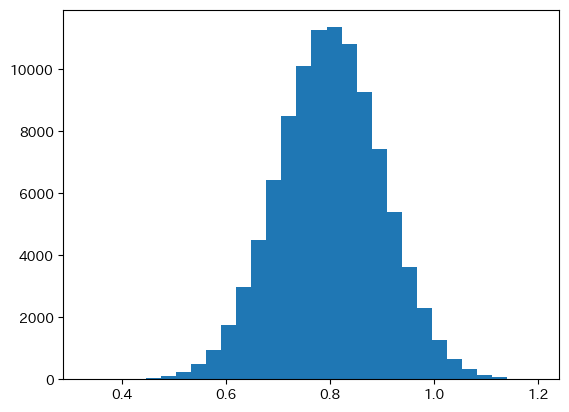

In [7]:
# 平均0.8, 分散0.1の正規分布に従う乱数を生成１０００個作成
r_mean = 0.8
r_std = 0.1
r = np.random.normal(r_mean, r_std, 100000)

# ヒストグラムを作成
plt.hist(r, bins=30)
plt.show()


In [6]:
r_std

0.31622776601683794

In [13]:
label_true = ["True PO", "True EBZ", "True EBPA2"]

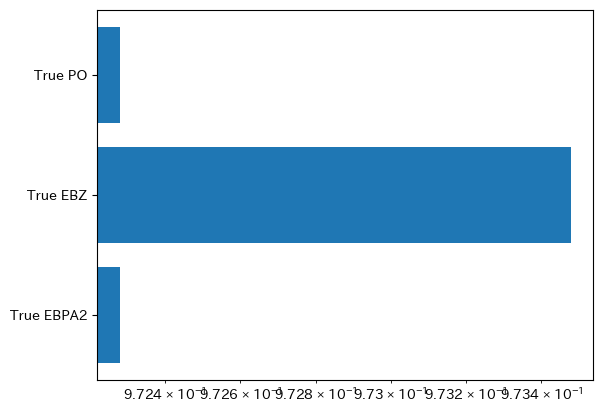

In [14]:
plt.barh(label_true, df_5_mean[label_true], capsize=3)

# 反転
plt.gca().invert_yaxis()

plt.xscale("log")
